In [12]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print("Error: ", e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Error:  Please provide a TPU Name to connect to.
Number of replicas: 1
2.17.0


In [4]:
def count_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [6]:
monet_filenames = tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_filenames))

n_monet_samples = count_items(monet_filenames)
n_photo_samples = count_items(photo_filenames)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [22]:
def decode_tfrec_image(img):
    features = tf.io.parse_single_example(
        img,
        features={
            'image': tf.io.FixedLenFeature([], tf.string)
        }
    )
    image = features['image']
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def load_dataset(filenames):
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(decode_tfrec_image, num_parallel_calls=AUTOTUNE)
    return ds

In [23]:
monet_ds = load_dataset(monet_filenames)
photo_ds = load_dataset(photo_filenames)

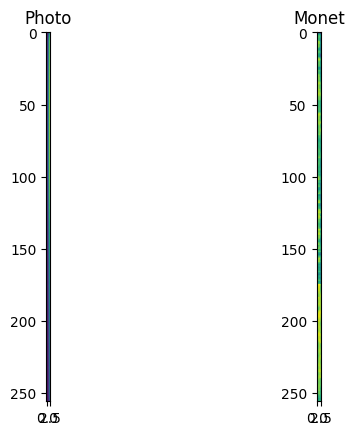

In [24]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)